# A. Importing the Data

In [2]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
from numpy.linalg import svd
from matplotlib.patches import Ellipse
from sklearn.cluster import KMeans
import matplotlib.patches as patch
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [3]:
data = pd.read_csv("iris.data", names = ["slength", "swidth", "plength", "pwidth", "class"])
data

,slength,swidth,plength,pwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


# B. Data Visualisation

I now use PCA to visualise the data-points of the Iris Dataset in 2 dimensions.

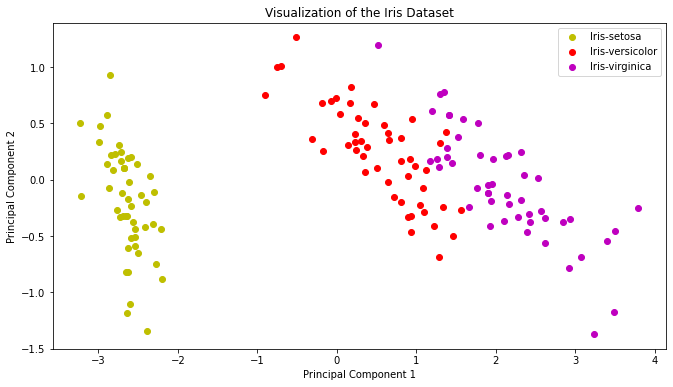

In [4]:
# pca function from lab 5 - returns the top n pcs 
def pca(X, n):
    u,s,v = svd(X, full_matrices=True)
    return v[:n,:]

y = data["class"]
X = data.iloc[:,0:4]
labels = np.unique(y)

#center the data
Xc = X - X.mean(axis=0)
#compute the top two principal components
pc = pca(Xc, 2)

#project onto top pcs
w = np.matrix.transpose(pc)
z = np.matmul(Xc,w)

colors = ['y', 'r', 'm']

# producing the graph
plt.rcParams["figure.figsize"] = (11,6)
for i in range(3):
    plt.scatter(x=z.loc[np.where(y==labels[i]),0], y=z.loc[np.where(y==labels[i]),1], color=colors[i])

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Visualization of the Iris Dataset")
plt.legend(labels,scatterpoints=1, loc='upper right')

plt.show()

# C. Clustering using GMM and the EM algorithm

In [5]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)

    # Draw the Ellipse
    for nsig in range(1, 5):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

In [6]:
#function to calculate mean vector, covariance matrix and pi from kmeans 
def calc_mean_cov(X, prediction):
    classes = np.unique(prediction)
    
    #initialise the dimension of the vector of means and covariance matrix
    d = X.shape[1]
    means = np.zeros((3,d))
    cov = np.zeros((3, d, d))
    pi = np.zeros(3)
    
    count=0
    for c in classes:
        #get indexes of points in cluster c
        id = np.where(prediction == c)
        #calculate probability of being in cluster c
        pi[count] = len(id[0]) / X.shape[0]
        #calculate the mean point of the cluster c
        means[count,:] = np.mean(X.iloc[id], axis = 0)

        #calculate the covariance of the cluster
        center = X.iloc[id] - means[count,:]
        n = X.iloc[id].shape[0]
        cov[count,:,:] = np.dot(pi[count]*center.T, center) / n
        count = count+1
    
    #ensure cluster probabilities add to 1
    assert np.sum(pi) == 1
    
    return (means, cov, pi)

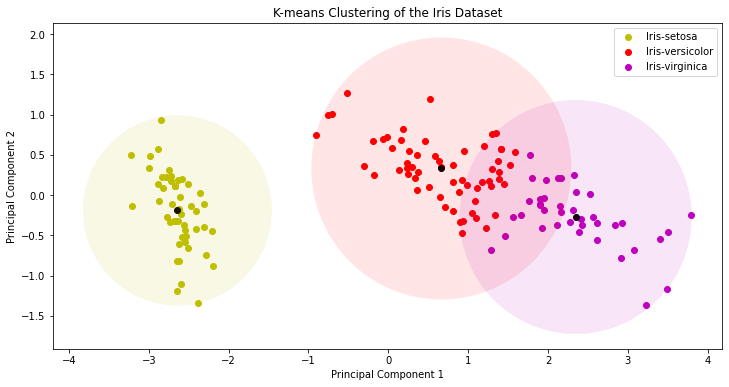

In [7]:
#fit the kmeans model
kmeans = KMeans(init="random", n_clusters = 3, n_init = 10, max_iter=300, random_state = 60)
kmeans.fit(z)
prediction = kmeans.predict(z)

#calculate the initial values from kmeans
mean, cov, pi = calc_mean_cov(z, prediction)
clusters_radii = dict()
clusters_centroids = dict()

#compute the mean of the clusters and the radius of the shape
for c in np.unique(prediction):
    clusters_centroids[c]=list(zip(kmeans.cluster_centers_[:, 0],kmeans.cluster_centers_[:,1]))[c]
    clusters_radii[c] = max([np.linalg.norm(np.subtract(i,clusters_centroids[c])) for i in zip(z.iloc[prediction == c, 0],z.iloc[prediction == c, 1])])

#produce the graph
fig, ax = plt.subplots(1,figsize=(12,6))
for i in range(3):
    plt.scatter(x=z.loc[np.where(prediction==i),0], y=z.loc[np.where(prediction==i),1], color=colors[i], label = labels[i])
    art = patch.Circle(clusters_centroids[i],clusters_radii[i],facecolor = colors[i], alpha = 0.1)
    ax.add_patch(art)
    
plt.scatter(x=mean[:,0], y=mean[:,1], color = "black")
plt.legend()
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-means Clustering of the Iris Dataset")
plt.show()

In [48]:
## Accuracy compared to ground truths for kmeans
#convert ground truth to 1-D numerical vector
truth = y
truth = np.where(y == 'Iris-setosa', 0, truth)
truth = np.where(y == 'Iris-versicolor', 1, truth)
truth = np.where(y == 'Iris-virginica', 2, truth)

print(accuracy_score(truth.tolist(), prediction.tolist()))
mean_squared_error(truth, prediction)

0.8866666666666667


0.11333333333333333

In [9]:
#E step to compute responsibilities
def E(X, pi, mean, cov):
    N = X.shape[0] 
    r = np.zeros((N, 3)) #responsibilities
    
    for c in range(3):
        #calculation of posterior distribution
        r[:,c] = pi[c] * mvn.pdf(X, mean[c,:], cov[c])
    
    #normalise to ensure they are valid probabilities
    r_norm = np.sum(r, axis =1)[:,np.newaxis]
    r /= r_norm
    return r

In [10]:
#M step updates the priors
def M(X, r):
    d = 2 #number of features
    mean = np.zeros((3,d)) 
    cov = np.zeros((3, d, d))
    pi = np.zeros(3)
    
    rsum = np.sum(r, axis = 0) #column sum of responsibilities
    #using the three equations from the coursework
    for c in range(3):
        pi[c] = rsum[c]/len(r)
        
        mean[c,:] = (1/rsum[c])*np.dot(r[:,c], X.loc[:,:])

        for i in range(len(X)):
            xi = np.matrix(X.loc[i,:])
            centered = xi - mean[c,:]
            cov[c,:,:] = cov[c,:,:] + r[i,c]*np.matmul(np.transpose(centered), centered)
        
        cov[c,:,:] = (1/rsum[c])*cov[c,:,:]

    return (mean, cov, pi)

In [45]:
def gmm(X, pi, mean, cov):
#returns instance of gmm

    count = 0
    for i in range(75):
        initial_pi = pi
        initial_mean = mean
        initial_cov = cov
        
        r = E(X, initial_pi, initial_mean, initial_cov)
        mean, cov, pi = M(X, r)
        
        count = count + 1
        # converges after 76 iterations
    
    return (mean, cov, pi, count, r) 

In [49]:
#gets the initial values from the k means
ini_mean, ini_cov, ini_pi = calc_mean_cov(z, prediction)

#runs the gmm algorithm
mean, cov, pi, count, r = gmm(z, ini_pi, ini_mean, ini_cov)

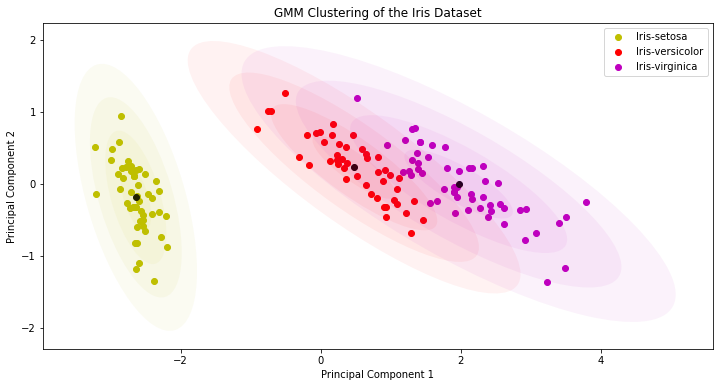

In [52]:
# hard assigns the responsibilities r
a = r
b = np.zeros_like(r)
b[np.arange(len(r)), a.argmax(1)] = 1

#returns the predictions made by running gmm algorithm
gmm_prediction = [0] * len(b)
for i in range(len(b)):
    gmm_prediction[i] = np.where(b[i,:] == 1)[0][0]
gmm_prediction = np.array(gmm_prediction)

#produces the graph
fig, ax = plt.subplots(1,figsize=(12,6))
for i in range(3):
    plt.scatter(x=z.loc[np.where(gmm_prediction==i),0], y=z.loc[np.where(gmm_prediction==i),1], color=colors[i], label = labels[i])
    draw_ellipse(mean[i,:], cov[i,:,:], alpha = 0.05 ,facecolor = colors[i])
    
plt.scatter(x=mean[:,0], y=mean[:,1], color = "black")
plt.legend()
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("GMM Clustering of the Iris Dataset")
plt.show()

In [51]:
## Accuracy compared to ground truths for gmm clustering
print(accuracy_score(truth.tolist(), gmm_prediction.tolist()))
print(mean_squared_error(truth, gmm_prediction))

0.9733333333333334
0.02666666666666667
